# Imported Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model #GARCH Models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import math
from statistics import NormalDist
from scipy.stats import t
from datetime import datetime
from scipy.stats import shapiro #Shapiro Test
from scipy import stats #t-test
import statsmodels.api as sm #Ljung-Box Test
from scipy.stats import chi2
import os

In [2]:
dir_name = "/Users/raph/Desktop/DESKTOP/Data/photos/Pred20Photos/BRW/"
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))

/var/folders/qg/90z639dn6ws7fn4d4_jsyky40000gn/T/ipykernel_38415/4229031027.py:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))


# Data

In [2]:
start_date = '2006-01-01' #yyyy-mm-dd
end_date = '2022-01-01'


#Philippines
PH = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/PSEi.csv')
PH['Date'] = pd.to_datetime(PH['Date'])
PH = PH.rename(columns={'Price': 'Close'})
PH = PH.replace(',','', regex=True)
PH['Close'] = PH['Close'].astype(float, errors = 'raise')
mask = (PH['Date'] >= start_date) & (PH['Date'] <= end_date)
PH = PH.loc[mask]
PH = PH.set_index('Date')
PH = PH.sort_index(axis=0, ascending = False)

#Malaysia
MY = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/%5EKLSE.csv')
MY['Date'] = pd.to_datetime(MY['Date'])
MY = MY.rename(columns={'Price': 'Close'})
MY = MY.replace(',','', regex=True)
MY['Close'] = MY['Close'].astype(float, errors = 'raise')
mask = (MY['Date'] >= start_date) & (MY['Date'] <= end_date)
MY = MY.loc[mask]
MY = MY.set_index('Date')
MY = MY.sort_index(axis=0, ascending = False).dropna()

#Signapore
SG = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/STI.csv')
SG['Date'] = pd.to_datetime(SG['Date'])
SG = SG.replace(',','', regex=True)
SG['Close'] = SG['Close'].astype(float, errors = 'raise')
mask = (SG['Date'] >= start_date) & (SG['Date'] <= end_date)
SG = SG.loc[mask]
SG= SG.set_index('Date')
SG = SG.sort_index(axis=0, ascending = False).dropna()

#Thailand
TH = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/SETi.csv')
TH['Date'] = pd.to_datetime(TH['Date'])
TH = TH.rename(columns={'Price': 'Close'})
TH = TH.replace(',','', regex=True)
TH['Close'] = TH['Close'].astype(float, errors = 'raise')
mask = (TH['Date'] >= start_date) & (TH['Date'] <= end_date)
TH = TH.loc[mask]
TH= TH.set_index('Date')
TH = TH.sort_index(axis=0, ascending = False).dropna()

#Vietnam
VT = pd.read_csv('https://raw.githubusercontent.com/raphaelyt/thesis199.11/main/data/2006-2021/HNX.csv')
VT['Date'] = pd.to_datetime(VT['Date'])
VT = VT.rename(columns={'Price': 'Close'})
VT = VT.replace(',','', regex=True)
VT['Close'] = VT['Close'].astype(float, errors = 'raise')
mask = (VT['Date'] >= start_date) & (VT['Date'] <= end_date)
VT = VT.loc[mask]
VT= VT.set_index('Date')
VT = VT.sort_index(axis=0, ascending = False).dropna()

# Logarithmic Returns

In [3]:
def get_returns(df,d):
    '''
    The function obtains the log returns of the asset shifted d days
    
    PARAMETERS
    ----------
    df : pandas.DataFrame
        The data frame contains data of a chosen stock index 
        (Stock index must be arrange in DESCENDING ORDER by DATE)
    d : int
        The dth day being forecast
        (Assumed to be 1 for most cases)
        
    RETURNS
    -------
    df : pandas.DataFrame
        The data frame returns an updated data frame containing the
        'Returns' column
    '''
    df['Previous'] = df['Close'].shift(-d)
    df['Returns'] = np.log(df['Close']/df['Previous'])*100
#     display(df)
    return df

PH = get_returns(PH, 1)
MY = get_returns(MY, 1)
SG = get_returns(SG, 1)
TH = get_returns(TH, 1)
VT = get_returns(VT, 1)

# Estimating VaR
## Parameters

In [4]:
alpha = 0.05
decay = 0.992

In [5]:
def get_weights_df(df, d, decay_par):
    count_returns = len(df["close"])-d # M
    weight_lst = [(1-decay_par)*(decay_par**j)/(1-decay_par**count_returns) for j in range(count_returns)]
    df["weight"] = pd.Series(weight_lst)
    return df

def get_ecdf(df):
    df = df.sort_values(by="change_in_value")
    df["ecdf"] = df["weight"].cumsum()
    return df

def get_VaR_BRW(df, alpha, decay_par):
    M = len(df['Returns'])
    weight_lst = [(1-decay_par)*(decay_par**j)/(1-decay_par**M) for j in range(M)]
    #display(weight_lst)
    weight_df = pd.DataFrame(weight_lst, columns = ['Weight'])
    df = df.reset_index()
    df = pd.merge(df, weight_df, left_index = True, right_index = True)
    df = df.set_index('Date')
    df = df.sort_values(by="Returns")
    df["ECDF"] = df["Weight"].cumsum()
    VaR = abs(np.interp(1-alpha, df["ECDF"], df["Returns"]))
    return round(VaR, 5)


def no_to_test(df, prediction_size):
    return int(np.ceil(len(df)*prediction_size))

# Fixed Window
## Parameters

In [6]:
prediction_size = 0.2
alpha = 0.0001
decay_par = 0.992
name = 'FW-BRW-0.01'

In [7]:
def fixed_window(df, prediction_size, alpha, decay_par):
    '''
    The function returns the (1-alpha)% d-day VaR of the asset staring at
    time t = test size to the present using a fixed time window of size test_size
    
    PARAMETERS
    ----------
    df : pandas.DataFrame
        The data frame contains data of a chosen stock index 
        (Stock index must be arrange in DESCENDING ORDER by DATE)
    prediction_size : float
        The test size is used to create a time window to estimate VaR
        using smaller time periods (The value must be inbetween 0 and 1)
    alpha : float 
        The level of significance of the VaR
        (Assumes a value in between 0 and 1)
    decay_par : float
        The parameter for the BRW approach. Standard value is 0.992-0.998.
        The parameter is a value between 0 and 1.
    
    RETURNS
    -------
    VaR_df : pandas.DataFrame
        The data frame contains the estimated (1-alpha)% d-day VaR from 
        time t = test size to current using the fixed time window 
    '''
    test_size = no_to_test(df, prediction_size)
    VaR_lst = np.zeros((test_size, 1))
    date_df = df[:test_size].reset_index()
    date_df = date_df.filter(['Date'])
    for i in range(test_size):
        temp_df = df[test_size-i:-(i+1)]
        temp_VaR = get_VaR_BRW(temp_df, alpha, decay_par)
        VaR_lst[i] = temp_VaR
    VaR_lst = VaR_lst[::-1]
    VaR_df = pd.DataFrame(VaR_lst, columns = ['Forecasted VaR'])
    VaR_df = pd.merge(date_df, VaR_df, left_index = True, right_index = True)
    VaR_df = VaR_df.set_index('Date')
    VaR_df.index = pd.to_datetime(VaR_df.index, utc = None)
    return VaR_df



PH_fw_brw = fixed_window(PH, prediction_size, alpha, decay_par)
MY_fw_brw = fixed_window(MY, prediction_size, alpha, decay_par)
SG_fw_brw = fixed_window(SG, prediction_size, alpha, decay_par)
TH_fw_brw = fixed_window(TH, prediction_size, alpha, decay_par)
VT_fw_brw = fixed_window(VT, prediction_size, alpha, decay_par)


In [21]:
PH_fw_brw.to_csv('/Users/raph/Desktop/Data/csv/PH_VaR_'+name+'.csv', index=True)
MY_fw_brw.to_csv('/Users/raph/Desktop/Data/csv/MY_VaR_'+name+'.csv', index=True)
SG_fw_brw.to_csv('/Users/raph/Desktop/Data/csv/SG_VaR_'+name+'.csv', index=True)
TH_fw_brw.to_csv('/Users/raph/Desktop/Data/csv/TH_VaR_'+name+'.csv', index=True)
VT_fw_brw.to_csv('/Users/raph/Desktop/Data/csv/VT_VaR_'+name+'.csv', index=True)

# VaR Violations FW

In [8]:
def char_function(df, window, prediction_size, name):
    '''
    The function returns the number of VaR violations.
    
    PARAMETERS
    ----------
    df : pandas.DataFrame
        The data frame contains data of a} chosen stock index 
        (Stock index must be arrange in DESCENDING ORDER by DATE)
        (Data frames must be the same size)
    window : pandas.DataFrame
        The data frame contains the estimated (1-alpha)% d-day VaR from 
        time t = test size to current using the rolling time window 
        (Data frames must be the same size)
        
    RETURNS
    -------
    N : int
        The value is the number of VaR violations
    '''
#     returns = abs(df['Returns'][:test_size].dropna())
    test_size = no_to_test(df, prediction_size)
    returns = df['Returns'][:test_size].dropna()
    f_returns = window['Forecasted VaR'].dropna()
    N = 0
    violation_lst = []
    for i, j in zip(returns, f_returns):
        if i < -j:
            violation_lst.append(1)
            N += 1 
        else:
            violation_lst.append(0)

    violations = pd.Series(violation_lst, index = returns.index, name = name)
    df = df.join(violations)
    display(N)
    return df, N

        

#Philippines
PH, PH_N_fw_brw = char_function(PH, PH_fw_brw, prediction_size, name)  

#Malaysia
MY, MY_N_fw_brw = char_function(MY, MY_fw_brw, prediction_size, name)     

#Singapore
SG, SG_N_fw_brw = char_function(SG, SG_fw_brw, prediction_size, name)      

#Thailand
TH, TH_N_fw_brw = char_function(TH, TH_fw_brw, prediction_size, name)

#Vietnam
VT, VT_N_fw_brw = char_function(VT, VT_fw_brw, prediction_size, name)

6

11

7

8

4

# Visualization of the Fixed Window

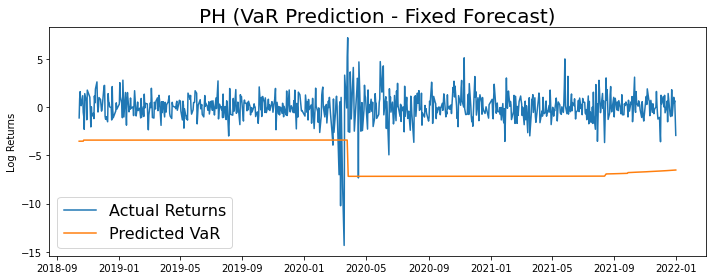

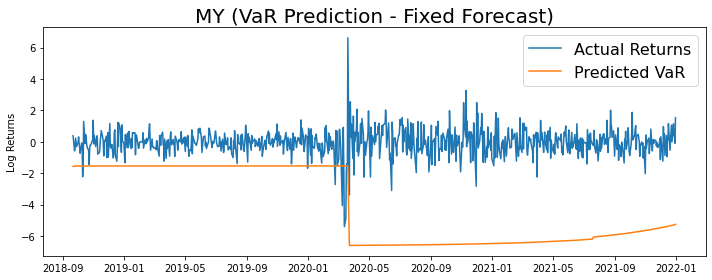

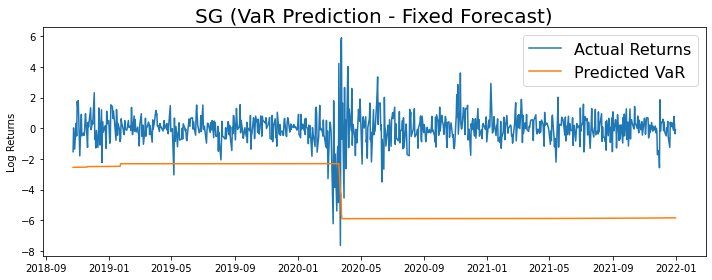

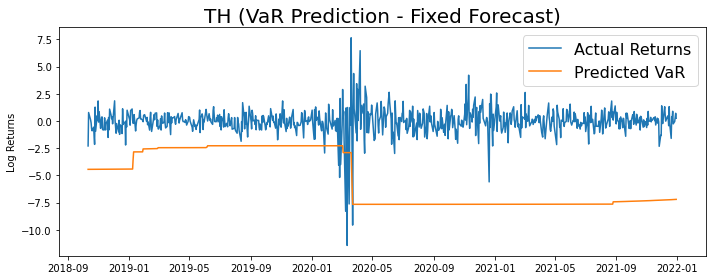

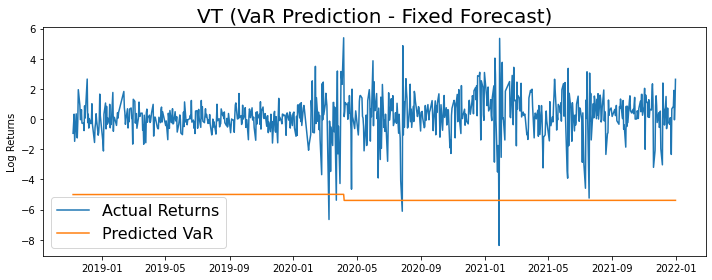

In [20]:
#Standard
#Philippines
plt.figure(figsize=(10,4))
plt.plot(PH['Returns'].iloc[:-(len(PH)-no_to_test(PH, prediction_size))])
plt.plot(-PH_fw_brw)
plt.ylabel('Log Returns')
plt.title('PH (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("PH_"+name+".png")

#Malaysia
plt.figure(figsize=(10,4))
plt.plot(MY['Returns'].iloc[:-(len(MY)-no_to_test(MY, prediction_size))])
plt.plot(-MY_fw_brw)
plt.ylabel('Log Returns')
plt.title('MY (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("MY_"+name+".png")

#Singapore
plt.figure(figsize=(10,4))
plt.plot(SG['Returns'].iloc[:-(len(SG)-no_to_test(SG, prediction_size))])
plt.plot(-SG_fw_brw)
plt.ylabel('Log Returns')
plt.title('SG (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("SG_"+name+".png")

#Thailand
plt.figure(figsize=(10,4))
plt.plot(TH['Returns'].iloc[:-(len(TH)-no_to_test(TH, prediction_size))])
plt.plot(-TH_fw_brw)
plt.ylabel('Log Returns')
plt.title('TH (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("TH_"+name+".png")

#Vietnam
plt.figure(figsize=(10,4))
plt.plot(VT['Returns'].iloc[:-(len(VT)-no_to_test(VT, prediction_size))])
plt.plot(-VT_fw_brw)
plt.ylabel('Log Returns')
plt.title('VT (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("VT_"+name+".png")

# Rolling Window
## Parameters

In [9]:
prediction_size = 0.2
alpha = 0.0001
decay_par = 0.992
name = 'RW-BRW-0.01'

In [10]:
def rolling_window(df, prediction_size, alpha, decay_par):
    '''
    The function returns the (1-alpha)% d-day VaR of the asset staring at
    time t = test size to the present using a smaller time window to begin
    and gradually increasing the size
    
    PARAMETERS
    ----------
    df : pandas.DataFrame
        The data frame contains data of a chosen stock index 
        (Stock index must be arrange in DESCENDING ORDER by DATE)
    test_size : int
        The test size is used to create a time window to estimate VaR
        using smaller time periods
        (The test size cannot be greater than the total number of entries
        of the data frame)
    alpha : float 
        The level of significance of the VaR
        (Assumes a value in between 0 and 1)
    decay_par : float
        The parameter for the BRW approach. Standard value is 0.992-0.998.
        The parameter is a value between 0 and 1.

    RETURNS
    -------
    VaR_df : pandas.DataFrame
        The data frame contains the estimated (1-alpha)% d-day VaR from 
        time t = test size to current using the rolling time window 
    '''
    test_size = no_to_test(df, prediction_size)
    VaR_lst = np.zeros((test_size,1))    
    date_df = df[:test_size].reset_index()
    date_df = date_df.filter(['Date'])
    for i in range(test_size):
        temp_df = df[test_size-i:]
        temp_VaR = get_VaR_BRW(temp_df, alpha, decay_par)
        VaR_lst[i] = temp_VaR
    VaR_lst = VaR_lst[::-1]
    VaR_df = pd.DataFrame(VaR_lst, columns = ['Forecasted VaR'])
    VaR_df = pd.merge(date_df, VaR_df, left_index = True, right_index = True)
    VaR_df = VaR_df.set_index('Date')
    return VaR_df

#Standard


PH_rw_brw = rolling_window(PH, prediction_size, alpha, decay_par)
MY_rw_brw = rolling_window(MY, prediction_size, alpha, decay_par)
SG_rw_brw = rolling_window(SG, prediction_size, alpha, decay_par)
TH_rw_brw = rolling_window(TH, prediction_size, alpha, decay_par)
VT_rw_brw = rolling_window(VT, prediction_size, alpha, decay_par)

In [30]:
PH_rw_brw.to_csv('/Users/raph/Desktop/Data/csv/PH_VaR_'+name+'.csv', index=True)
MY_rw_brw.to_csv('/Users/raph/Desktop/Data/csv/MY_VaR_'+name+'.csv', index=True)
SG_rw_brw.to_csv('/Users/raph/Desktop/Data/csv/SG_VaR_'+name+'.csv', index=True)
TH_rw_brw.to_csv('/Users/raph/Desktop/Data/csv/TH_VaR_'+name+'.csv', index=True)
VT_rw_brw.to_csv('/Users/raph/Desktop/Data/csv/VT_VaR_'+name+'.csv', index=True)

# VaR Violation RW

In [11]:
#Philippines
PH, PH_N_rw_brw = char_function(PH, PH_rw_brw, prediction_size, name) 

#Malaysia
MY, MY_N_rw_brw = char_function(MY, MY_rw_brw, prediction_size, name)

#Singapore
SG, SG_N_rw_brw = char_function(SG, SG_rw_brw, prediction_size, name)

#Thailand
TH, TH_N_rw_brw = char_function(TH, TH_rw_brw, prediction_size, name)

#Vietnam
VT, VT_N_rw_brw = char_function(VT, VT_rw_brw, prediction_size, name)

6

11

7

8

4

# Visualization of the Rolling Window

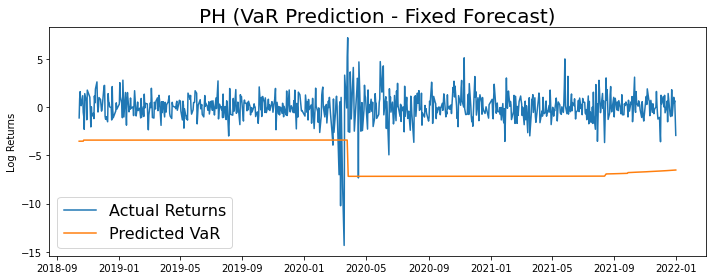

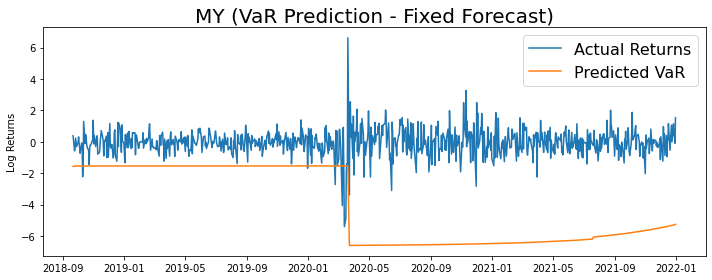

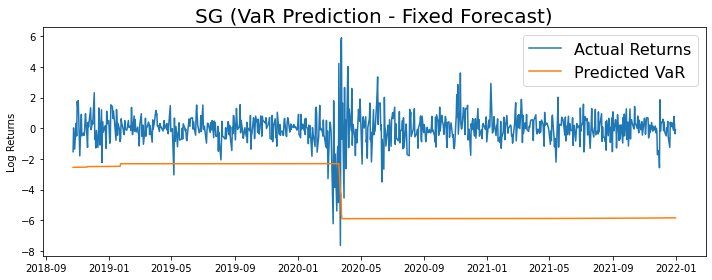

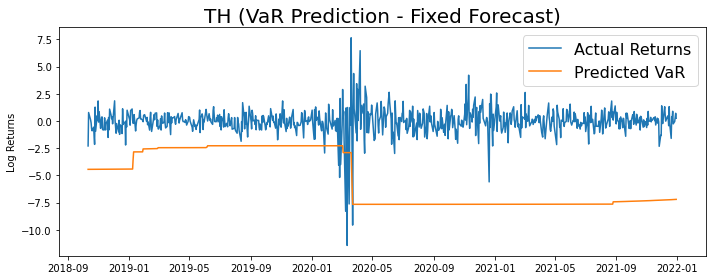

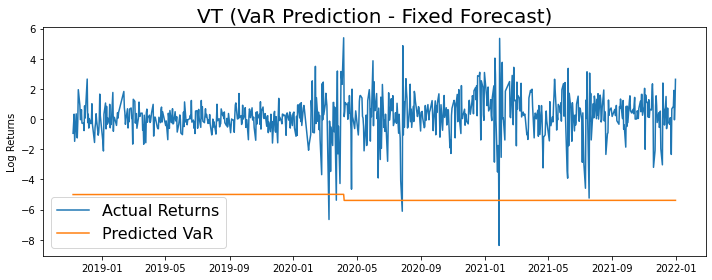

In [23]:
#Standard
#Philippines
plt.figure(figsize=(10,4))
plt.plot(PH['Returns'].iloc[:-(len(PH)-no_to_test(PH, prediction_size))])
plt.plot(-PH_rw_brw)
plt.ylabel('Log Returns')
plt.title('PH (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("PH_"+name+".png")

#Malaysia
plt.figure(figsize=(10,4))
plt.plot(MY['Returns'].iloc[:-(len(MY)-no_to_test(MY, prediction_size))])
plt.plot(-MY_rw_brw)
plt.ylabel('Log Returns')
plt.title('MY (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("MY_"+name+".png")

#Singapore
plt.figure(figsize=(10,4))
plt.plot(SG['Returns'].iloc[:-(len(SG)-no_to_test(SG, prediction_size))])
plt.plot(-SG_rw_brw)
plt.ylabel('Log Returns')
plt.title('SG (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("SG_"+name+".png")

#Thailand
plt.figure(figsize=(10,4))
plt.plot(TH['Returns'].iloc[:-(len(TH)-no_to_test(TH, prediction_size))])
plt.plot(-TH_rw_brw)
plt.ylabel('Log Returns')
plt.title('TH (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("TH_"+name+".png")

#Vietnam
plt.figure(figsize=(10,4))
plt.plot(VT['Returns'].iloc[:-(len(VT)-no_to_test(VT, prediction_size))])
plt.plot(-VT_rw_brw)
plt.ylabel('Log Returns')
plt.title('VT (VaR Prediction - Fixed Forecast)', fontsize=20)
plt.legend(['Actual Returns', 'Predicted VaR'], fontsize=16)
plt.savefig("VT_"+name+".png")

# Suffieincy of the Model


## Unconditional Coverage

In [23]:
def CI_UC(alpha, ss):
    '''
    The function returns an (1-alpha)% confidence interval for N
    
    PARAMETERS
    ----------
    alpha : float 
        The level of significance of the VaR
        (Assumes a value in between 0 and 1)
    ss : int
        The total number of entries in the data frame of the asset
        
    RETURNS
    -------
    CI : list
        The list is the (1-alpha)% confidence interval
    '''
    CI = []
    a = np.ceil(alpha*ss - (NormalDist().inv_cdf(1-alpha/2))*np.sqrt(ss*alpha*(1-alpha)))
    b = np.ceil(alpha*ss + (NormalDist().inv_cdf(1-alpha/2))*np.sqrt(ss*alpha*(1-alpha)))
    CI.append(a)
    CI.append(b)
    return CI


alpha = 0.0001
print(CI_UC(alpha,prediction_size))


[-0.0, 1.0]


## Chi-squared Test (1 DoF)

In [28]:
alpha = 0.0001

round(chi2.ppf(1-alpha, df = 1), 4)

15.1367

## Conditional Coverage

In [25]:
chi2.ppf(1-alpha, df = 2)

5.991464547107979

# Parameters

In [19]:
alpha = 0.0001
entries1 = no_to_test(PH, prediction_size)
entries2 = no_to_test(MY, prediction_size)
entries3 = no_to_test(SG, prediction_size)
entries4 = no_to_test(TH, prediction_size)
entries5 = no_to_test(VT, prediction_size)
name_1 = 'FW-BRW-0.01'
name_2 = 'RW-BRW-0.01'


# Kupiec Test

In [16]:
def LR_kupiec(N, observations, alpha):
    p = alpha
    a = -2*np.log((((1-p)**(observations - N))*(p**N))/(((1-N/observations)**(observations - N))*((N/observations)**N)))
    display(round(a,4))
    return a



#Philippines
PH_LRk_fw_brw = LR_kupiec(PH_N_fw_brw, entries1, alpha)
PH_LRk_rw_brw = LR_kupiec(PH_N_rw_brw, entries1, alpha)

#Malaysia
MY_LRk_fw_brw = LR_kupiec(MY_N_fw_brw, entries2, alpha)
MY_LRk_rw_brw = LR_kupiec(MY_N_rw_brw, entries2, alpha)

#Singapore
SG_LRk_fw_brw = LR_kupiec(SG_N_fw_brw, entries3, alpha)
SG_LRk_rw_brw = LR_kupiec(SG_N_rw_brw, entries3, alpha)

#Thailand
TH_LRk_fw_brw = LR_kupiec(TH_N_fw_brw, entries4, alpha)
TH_LRk_rw_brw = LR_kupiec(TH_N_rw_brw, entries4, alpha)

#Vietnam
VT_LRk_fw_brw = LR_kupiec(VT_N_fw_brw, entries5, alpha)
VT_LRk_rw_brw = LR_kupiec(VT_N_rw_brw, entries5, alpha)

40.2995

40.2995

86.3292

86.3292

48.7709

48.7709

58.3041

58.3041

23.5644

23.5644

# Christoffersen Test
## Part 1

In [17]:
def no_of_periods(df, name):
    n00 = 0
    n01 = 0
    n10 = 0
    n11 = 0
    violations = df[name].dropna()[::-1]
    v_p = violations[0]
    i = 1
    while i < len(violations):
        if v_p == violations[i] and v_p == 0:
            n00 += 1
        elif v_p != violations[i] and v_p == 0:
            n01 += 1
        elif v_p != violations[i] and v_p == 1:
            n10 += 1
        else:
            n11 += 1
        v_p = violations[i]
        i += 1 
    return n00, n01, n10, n11

## Part 2

In [20]:
def LR_ind(df, name, LR_pof):
    n00, n01, n10, n11 = no_of_periods(df, name)
    pi_0 = n01/(n00+n01)
    pi_1 = n11/(n10+n11)
    pi = (n01+n11)/(n00+n01+n10+n11)
    LR_ind = -2*np.log((((1-pi)**(n00+n01))*(pi**(n01+n11)))/(((1-pi_0)**n00)*(pi_0**n01)*((1-pi_1)**n10)*(pi_1**n11)))
    LR_cc = LR_ind+LR_pof
    display(round(LR_cc,4))
    return LR_ind, LR_cc

#Philippines
PH_LRcci_fw_brw, PH_LRcc_fw_brw = LR_ind(PH, name_1, PH_LRk_fw_brw)
PH_LRcci_rw_brw, PH_LRcc_rw_brw = LR_ind(PH, name_2, PH_LRk_rw_brw)

#Malaysia
MY_LRcci_fw_brw, MY_LRcc_fw_brw = LR_ind(MY, name_1, MY_LRk_fw_brw)
MY_LRcci_rw_brw, MY_LRcc_rw_brw = LR_ind(MY, name_2, MY_LRk_rw_brw)

#Singapore
SG_LRcci_fw_brw,SG_LRcc_fw_brw = LR_ind(SG, name_1, SG_LRk_fw_brw)
SG_LRcci_rw_brw,SG_LRcc_rw_brw = LR_ind(SG, name_2, SG_LRk_rw_brw)

#Thailand
TH_LRcci_fw_brw,TH_LRcc_fw_brw = LR_ind(TH, name_1, TH_LRk_fw_brw)
TH_LRcci_rw_brw,TH_LRcc_rw_brw = LR_ind(TH, name_2, TH_LRk_rw_brw)

#Vietnam
VT_LRcci_fw_brw,VT_LRcc_fw_brw = LR_ind(VT, name_1, VT_LRk_fw_brw)
VT_LRcci_rw_brw,VT_LRcc_rw_brw = LR_ind(VT, name_2, VT_LRk_rw_brw)

44.868

44.868

108.0768

108.0768

48.8942

48.8942

58.4699

58.4699

23.6051

23.6051